$$
\begin{equation}
\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0
\end{equation}
$$

$$
\begin{equation}
F = \rho u_{\rm max} \left(1-\frac{\rho}{\rho_{\rm max}}\right)
\end{equation}
$$



$$
\begin{equation}
\rho(x,0) = \left\{
\begin{array}{cc}
0.5 \rho_{\rm max} & 0 \leq x < 3  \\
\rho_{\rm max} & 3 \leq x \leq 4 \\
\end{array}
\right.
\end{equation}
$$


\begin{align}
&\rho_i^{n+1} = \rho_i^n - \frac{\Delta t}{2 \Delta x} \left(F^n_{i+1}-F^n_{i-1}\right) + \cdots \\ \nonumber 
&+ \frac{(\Delta t)^2}{4(\Delta x)^2} \left[ (J^n_{i+1}+J^n_i)(F^n_{i+1}-F^n_i)-(J^n_i+J^n_{i-1})(F^n_i-F^n_{i-1})\right]
\end{align}

\begin{equation}J^n_i = \frac{\partial F}{\partial \rho} = u_{\rm max} \left(1-2\frac{\rho^n_i}{\rho_{\rm max}} \right).\end{equation} 

In [179]:
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline 

In [180]:
np.set_printoptions(precision=3)
plt.style.use('dark_background')
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']='16'

In [181]:
def rho_green_light(x, rho_light):
    rho=rho_max*np.ones_like(x)
    mask=np.where(x<3.0)
    rho[mask]=rho_max*0.5
    return rho

In [182]:
nx=81
L=4
dx=L/(nx-1)
nt=40
CFL=np.array([0.1, 0.2, 0.3, 0.4, 1.0])
cases=np.size(CFL)
u_max=1.0
dt=CFL*dx/u_max
rho_max=10.0
x=np.linspace(0.0, L, num=nx)
rho0=rho_green_light(x, rho_light)

(-0.5, 11.0)

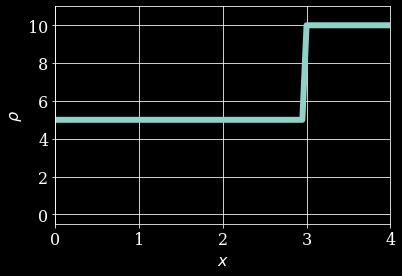

In [183]:
plt.figure(figsize=(6.0, 4.0))
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho$')
plt.grid()
plt.plot(x, rho0, color='C0', linestyle='-', linewidth=6)
plt.xlim(0.0, L)
plt.ylim(-0.5, 11.0)

In [184]:
def flux(rho, u_max, rho_max):
    F=rho*u_max*(1-rho/rho_max)
    return F

In [185]:
def laxfriedrichs(rho1, u_max, rho_max, CFL0, nt, rho0):
    for n in range(nt-1):
        F=flux(rho1[n], u_max, rho_max)
        rho1[n+1,0]=rho0[0]
        rho1[n+1,-1]=rho0[-1]
        rho1[n+1,1:-1]=0.5*(rho1[n,2:]+rho1[n, 0:-2])-0.5*CFL0*(F[2:]-F[0:-2])/u_max
    return rho1

In [186]:
def Jacobian(rho1, u_max, rho_max):
    J=u_max*(1-2*rho1/rho_max)
    return J

\begin{align}
&\rho_i^{n+1} = \rho_i^n - \frac{\Delta t}{2 \Delta x} \left(F^n_{i+1}-F^n_{i-1}\right) + \cdots \\ \nonumber 
&+ \frac{(\Delta t)^2}{4(\Delta x)^2} \left[ (J^n_{i+1}+J^n_i)(F^n_{i+1}-F^n_i)-(J^n_i+J^n_{i-1})(F^n_i-F^n_{i-1})\right]
\end{align}

In [199]:
def laxwendroff(rho1, u_max, rho_max, CFL0, nt, rho0):
    for n in range(nt-1):
        F=flux(rho1[n], u_max, rho_max)
        J=Jacobian(rho1[n], u_max, rho_max)
        rho1[n+1,0]=rho0[0]
        rho1[n+1,-1]=rho0[-1]
        rho1[n+1,1:-1]=rho1[n, 1:-1]-CFL0*0.5/u_max*(F[2:]-F[0:-2])+0.25*(CFL0/u_max)**2*((J[2:]+J[1:-1])*(F[2:]-F[1:-1])-(J[1:-1]+J[0:-2])*(F[1:-1]-F[0:-2]))
    return rho1

$$
\begin{equation}
\rho^*_i = \rho^n_i - \frac{\Delta t}{\Delta x} (F^n_{i+1}-F^n_{i}) \ \ \ \ \ \ \text{(predictor)}
\end{equation}
$$


$$
\begin{equation}
\rho^{n+1}_i = \frac{1}{2} (\rho^n_i + \rho^*_i - \frac{\Delta t}{\Delta x} (F^*_i - F^{*}_{i-1})) \ \ \ \ \ \ \text{(corrector)}
\end{equation}
$$

In [209]:
def maccormack(rho1, u_max, rho_max, CFL0, nt, rho0):
    for n in range(nt-1):
        F=flux(rho1[n], u_max, rho_max)
        rho1[n+1,0]=rho0[0]
        rho1[n+1,-1]=rho0[-1]
        rho1[n+1,1:-1]=rho1[n, 1:-1]-CFL0/u_max*(F[2:]-F[1:-1])
        F1=flux(rho1[n+1], u_max, rho_max)
        rho1[n+1,0]=rho0[0]
        rho1[n+1,-1]=rho0[-1]
        rho1[n+1,1:-1]=0.5*(rho1[n, 1:-1]+rho1[n+1, 1:-1]-CFL0/u_max*(F1[1:-1]-F1[0:-2]))
    return rho1

In [210]:
F=flux(rho0, u_max, rho_max)
np.shape(F[1:-1])

(79,)

In [211]:
rho_values=[]
for CFL0 in CFL:
    rho1=np.empty((nt, nx))
    rho1[0]=rho0
    rho1=maccormack(rho1, u_max, rho_max, CFL0, nt, rho0)
    rho_values.append(rho1)

In [212]:
stackrho_values=rho_values[0]
for n in range(cases-1):
    stackrho_values=np.vstack((stackrho_values, rho_values[n+1]))

In [213]:
from matplotlib import animation
from IPython.display import HTML

(-0.5, 11.0)

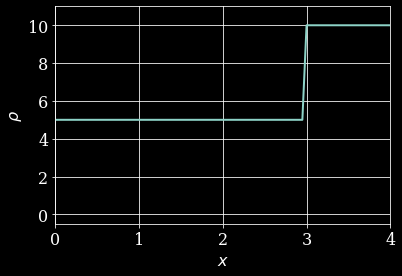

In [214]:
fig = plt.figure(figsize=(6.0, 4.0))
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho$')
plt.grid()
line = plt.plot(x, rho_values[0][0,:],
                    color='C0', linestyle='-', linewidth=2)[0]
plt.xlim(0.0, L)
plt.ylim(-0.5, 11.0)

In [215]:
def update_plot(n, stackrho_values):
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(stackrho_values[n,:])

In [216]:
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt*5, fargs=(stackrho_values,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())